In [225]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500)
pd.options.display.max_rows = 999999

In [226]:
#Reading data
df = pd.read_csv('companies2.csv')

In [227]:
#Removing columns and rows not relevant for this analysis
df = df.drop(['Headquarters Location'], axis=1)
df = df.dropna(subset=['Funding Status'])

In [228]:
#Label encoding the funding status column
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['Funding Status'])
df['Funding Status'] = le.transform(df['Funding Status'])

In [229]:
#Further dropping unnecessary columns
nn = df.drop(['Organization Name', 'Categories', 'CB Rank (Company)', 'Top 5 Investors', 'Estimated Revenue Range'], axis=1)

In [230]:
#Applying gender guesser to CEO of each startup
import gender_guesser.detector as gender
d = gender.Detector()
nn['Founder Gender'] = [d.get_gender(x) for x in nn['Founders'].str.split().str.get(0)]
nn['Founder Gender'] = nn['Founder Gender'].replace({'mostly_male':'male', 'mostly_female':'female'})

In [231]:
#Removing non-numeric characters from columns
cols = ['SimilarWeb - Average Visits (6 months)', 
        'SimilarWeb - Visit Duration', 'SimilarWeb - Monthly Visits Growth']
for x in cols:
    nn[x] = nn[x].str.replace(",", "")
    nn[x] = nn[x].str.replace("%", "")
    nn[x] = pd.to_numeric(nn[x])
    nn = nn.fillna({x:nn[x].mean()})
    
cols2 = ['SimilarWeb - Monthly Visits', 'Apptopia - Downloads Last 30 Days', 
        'Number of Articles', 'IPqwery - Patents Granted', 'IPqwery - Trademarks Registered']
for x in cols2:
    nn[x] = nn[x].str.replace(",", "")
cols3 = ['Number of Founders']
for x in cols3:
    nn[x] = pd.to_numeric(nn[x])
    nn = nn.fillna({x:nn[x].mean()})

In [232]:
#One-hot encoding for funding status
nn = nn.dropna(subset=['Funding Status'])
nn = pd.concat([nn,pd.get_dummies(nn['Funding Status'])], axis=1)
nn = nn.drop(['Funding Status'], axis=1)
nn = nn.rename(columns={0:'early', 1:'ipo', 2:'late', 3:'ma', 4:'seed'})

In [233]:
#Cleaning up date format
nn = nn.dropna(subset=['Founded Date'])
nn['Founded Date'] = nn['Founded Date'].str[:-6]
nn['Closed Date'] = nn['Closed Date'].str[:-6]

In [234]:
#Resetting index
nn = nn.reset_index()
nn = nn.drop(['index'], axis=1)

In [235]:
#One-hot encoding for number of employees
nn = pd.concat([nn,pd.get_dummies(nn['Number of Employees'])], axis=1)
nn = nn.drop(['Number of Employees'], axis=1)
nn = nn.rename(columns={'10-Jan': '1-10'})

In [236]:
#One-hot encoding for gender, removing unknown and andy (androgynous) columns as well as Founder Gender column
nn = pd.concat([nn,pd.get_dummies(nn['Founder Gender'])], axis=1)
nn = nn.drop(['andy', 'unknown', 'Founder Gender'], axis=1)

In [238]:
#Defining success and failure
#0 is failure, based on entries that have closing dates or entries that have failed to leave
#early stages after 4 years
#2 is success, based on entries that made it to later, more successful stages
#1 is medium, based on entries that are currently alive but not failed, or for entries 
#that do not have enough information for a definitive conclusion of success or failure
nn['Success'] = ""
shape = nn.shape[1]-1
nn['Founded Date'] = pd.to_numeric(nn['Founded Date'])
nn['Success'] = pd.to_numeric(nn['Success'])
long = np.where(np.array(2019 - nn['Founded Date'] > 4))
for x in long:
    nn.iloc[x, shape] = 0
success1 = np.where(np.array(nn['ipo'] == 1))
success2 = np.where(np.array(nn['late'] == 2))
success3 = np.where(np.array(nn['ma'] == 3))
failed1 = np.array(nn['Closed Date'])
for x in success1:
    nn.iloc[x, shape] = 2
for x in success2:
    nn.iloc[x, shape] = 2 
for x in success3:
    nn.iloc[x, shape] = 2

failed1 = [isinstance(x,str) for x in failed1]
j = np.array([])
i = 0
for x in failed1:
    i += 1
    if x == True:
        j = np.append(j, i)
for x in j:
    nn.iloc[int(x), shape] = 0
nn['Success'] = nn['Success'].fillna(1)

In [239]:
#Imputing missing data
nn = nn.fillna({'Number of Lead Investors':nn['Number of Lead Investors'].mean(), 
                'Number of Investors':nn['Number of Investors'].mean(),
                'Number of Funding Rounds':nn['Number of Funding Rounds'].mean(),
                'Total Equity Funding Amount Currency (in USD)':nn['Total Equity Funding Amount Currency (in USD)'].mean(),
                'Total Funding Amount Currency (in USD)':nn['Total Funding Amount Currency (in USD)'].mean(),
                'Number of Articles':0,
                'SimilarWeb - Monthly Visits':0,
                'Closed Date':0, 'Apptopia - Number of Apps':0, 'Apptopia - Downloads Last 30 Days':0,
                'IPqwery - Patents Granted':0, 'IPqwery - Trademarks Registered':0, 'Siftery - Total Products Active':1})

nn = nn.drop(['Founders'], axis=1)
shape -= 1

In [255]:
#Train test split with 20% data for testing
x = np.array(nn.iloc[:,:37])
y = np.array(nn.iloc[:,37])
from sklearn import model_selection
x_train2, x_test2, y_train2, y_test2 = model_selection.train_test_split(x,y,test_size=0.2)

Train on 2358 samples, validate on 263 samples
Epoch 1/50
2358/2358 [==============================] - 3s 1ms/step - loss: 0.6924 - acc: 0.5280 - val_loss: 0.6883 - val_acc: 0.5513
Epoch 2/50
2358/2358 [==============================] - 0s 72us/step - loss: 0.6899 - acc: 0.5428 - val_loss: 0.6881 - val_acc: 0.5513
Epoch 3/50
2358/2358 [==============================] - 0s 66us/step - loss: 0.6897 - acc: 0.5428 - val_loss: 0.6879 - val_acc: 0.5513
Epoch 4/50
2358/2358 [==============================] - 0s 67us/step - loss: 0.6896 - acc: 0.5428 - val_loss: 0.6878 - val_acc: 0.5513
Epoch 5/50
2358/2358 [==============================] - 0s 66us/step - loss: 0.6896 - acc: 0.5428 - val_loss: 0.6882 - val_acc: 0.5513
Epoch 6/50
2358/2358 [==============================] - 0s 71us/step - loss: 0.6895 - acc: 0.5428 - val_loss: 0.6880 - val_acc: 0.5513
Epoch 7/50
2358/2358 [==============================] - 0s 110us/step - loss: 0.6891 - acc: 0.5428 - val_loss: 0.6881 - val_acc: 0.5513
Epoch 8/

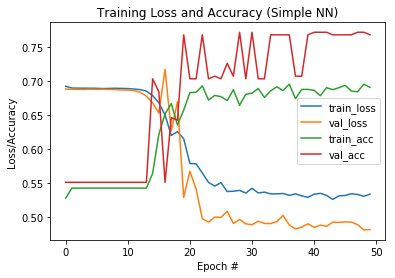

In [256]:
#Creating neural network with 5 dense layers and 3 dropout layers
#Fitting on data, accuracy and loss visualization below
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding
model2 = Sequential()
model2.add(Dense(35, activation='sigmoid'))
model2.add(Dropout(0.02))
model2.add(Dense(26, activation='relu'))
model2.add(Dense(22, activation='relu'))
model2.add(Dense(12, activation='relu'))
model2.add(Dense(6, activation='relu'))
model2.add(Dropout(0.02))
model2.add(Dense(4, activation='relu'))
model2.add(Dropout(0.02))
model2.add(Dense(3, activation='sigmoid'))
from keras.optimizers import SGD
opt = SGD(lr=0.2)
model2.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])
from keras.utils import to_categorical
y_binarytrain2 = to_categorical(y_train2)
y_binarytest2 = to_categorical(y_test2)

final2 = model2.fit(x_train2, y_binarytrain2, validation_data=(x_test2, y_binarytest2), epochs=50)

import matplotlib
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt
N = np.arange(0, 50)
plt.figure()
plt.plot(N, final2.history["loss"], label="train_loss")
plt.plot(N, final2.history["val_loss"], label="val_loss")
plt.plot(N, final2.history["acc"], label="train_acc")
plt.plot(N, final2.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy (Simple NN)")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('Loss and accuracy3')
plt.show()